<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/Farmer_Input_Purchase_Analysis_Association_Rule_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Create a realistic Kenyan farmer input purchases dataset
np.random.seed(42)

# Define common agricultural inputs in Kenya
inputs = [
    'Maize_Seeds', 'Bean_Seeds', 'NPK_Fertilizer', 'CAN_Fertilizer', 'Urea',
    'Pesticides', 'Herbicides', 'Fungicides', 'Organic_Manure', 'Lime',
    'Irrigation_Equipment', 'Sprayers', 'Water_Pumps', 'Protective_Gear'
]

# Generate transaction data
n_transactions = 2000
transactions = []

for i in range(n_transactions):
    transaction_id = f"T{1000 + i}"
    farmer_id = f"F{np.random.randint(1000, 9999)}"
    region = np.random.choice(['Central', 'Rift Valley', 'Western', 'Nyanza', 'Eastern', 'Coastal'])
    season = np.random.choice(['Long Rains', 'Short Rains', 'Dry Season'])

    # Base number of items based on region and season
    if region in ['Central', 'Western']:
        base_items = np.random.randint(3, 8)
    else:
        base_items = np.random.randint(2, 6)

    # Select items
    n_items = np.random.poisson(base_items)
    n_items = max(2, min(n_items, len(inputs)))

    purchased_items = np.random.choice(inputs, n_items, replace=False)

    transactions.append({
        'transaction_id': transaction_id,
        'farmer_id': farmer_id,
        'region': region,
        'season': season,
        'items': list(purchased_items)
    })

# Create DataFrame
df = pd.DataFrame(transactions)
print("Dataset created successfully!")
print(f"Total transactions: {len(df)}")
print(f"Total unique farmers: {df['farmer_id'].nunique()}")

Dataset created successfully!
Total transactions: 2000
Total unique farmers: 1805


=== DATA EXPLORATION ===
Dataset shape: (2000, 5)
Regions: [np.str_('Nyanza') np.str_('Coastal') np.str_('Eastern')
 np.str_('Central') np.str_('Western') np.str_('Rift Valley')]
Seasons: [np.str_('Long Rains') np.str_('Short Rains') np.str_('Dry Season')]

Average items per transaction: 4.21
Maximum items in transaction: 14

Regional Statistics:
             num_items  transaction_count
region                                   
Central       5.110119                336
Coastal       3.714681                361
Eastern       3.610390                308
Nyanza        3.780980                347
Rift Valley   3.822581                310
Western       5.215976                338

Seasonal Statistics:
             num_items  transaction_count
season                                   
Dry Season    4.251944                643
Long Rains    4.156204                685
Short Rains   4.239583                672


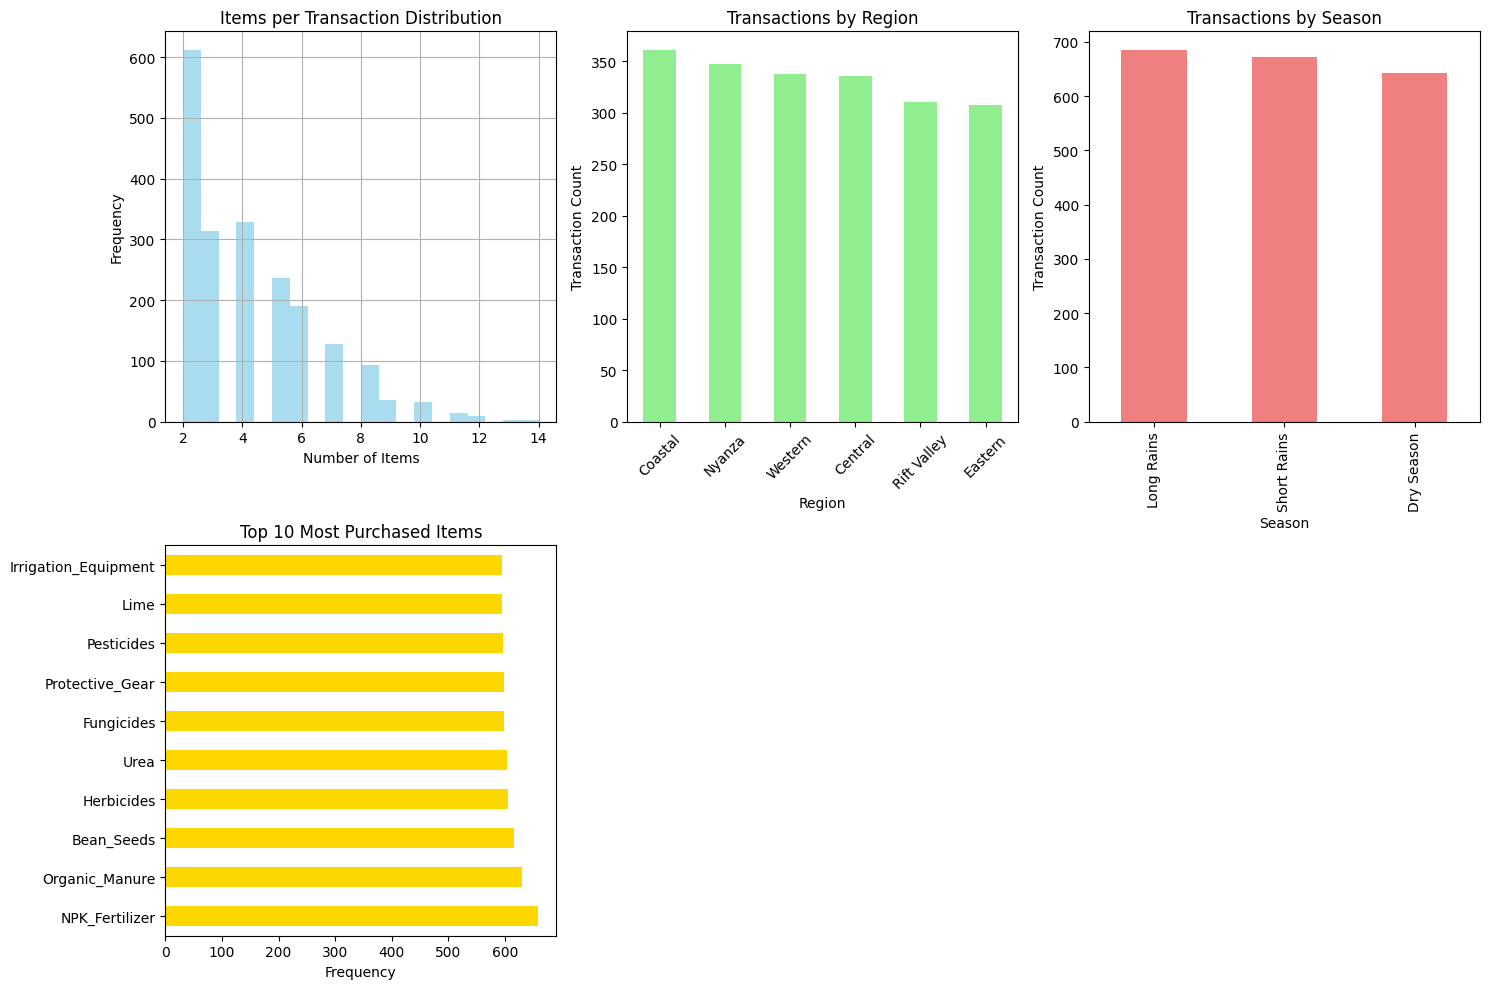

In [2]:
# Data Preprocessing
def preprocess_data(df):
    """Preprocess the farmer transactions data"""

    # 1. Explore basic statistics
    print("=== DATA EXPLORATION ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Regions: {df['region'].unique()}")
    print(f"Seasons: {df['season'].unique()}")

    # 2. Calculate items per transaction
    df['num_items'] = df['items'].apply(len)

    print(f"\nAverage items per transaction: {df['num_items'].mean():.2f}")
    print(f"Maximum items in transaction: {df['num_items'].max()}")

    # 3. Regional analysis
    regional_stats = df.groupby('region').agg({
        'num_items': 'mean',
        'transaction_id': 'count'
    }).rename(columns={'transaction_id': 'transaction_count'})

    print("\nRegional Statistics:")
    print(regional_stats)

    # 4. Seasonal analysis
    seasonal_stats = df.groupby('season').agg({
        'num_items': 'mean',
        'transaction_id': 'count'
    }).rename(columns={'transaction_id': 'transaction_count'})

    print("\nSeasonal Statistics:")
    print(seasonal_stats)

    return df

# Preprocess the data
df = preprocess_data(df)

# Visualize the data
plt.figure(figsize=(15, 10))

# Plot 1: Items distribution
plt.subplot(2, 3, 1)
df['num_items'].hist(bins=20, alpha=0.7, color='skyblue')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.title('Items per Transaction Distribution')

# Plot 2: Regional distribution
plt.subplot(2, 3, 2)
df['region'].value_counts().plot(kind='bar', color='lightgreen')
plt.xlabel('Region')
plt.ylabel('Transaction Count')
plt.title('Transactions by Region')
plt.xticks(rotation=45)

# Plot 3: Seasonal distribution
plt.subplot(2, 3, 3)
df['season'].value_counts().plot(kind='bar', color='lightcoral')
plt.xlabel('Season')
plt.ylabel('Transaction Count')
plt.title('Transactions by Season')

# Plot 4: Popular items
plt.subplot(2, 3, 4)
all_items = [item for sublist in df['items'] for item in sublist]
item_counts = pd.Series(all_items).value_counts().head(10)
item_counts.plot(kind='barh', color='gold')
plt.xlabel('Frequency')
plt.title('Top 10 Most Purchased Items')

plt.tight_layout()
plt.show()

In [3]:
# Prepare data for association rule mining
def prepare_transaction_data(df):
    """Convert transaction data to basket format"""

    # Create a list of all transactions
    transactions_list = df['items'].tolist()

    # Create a DataFrame for one-hot encoding
    from mlxtend.preprocessing import TransactionEncoder

    te = TransactionEncoder()
    te_ary = te.fit(transactions_list).transform(transactions_list)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)

    print(f"Basket dataset shape: {basket_df.shape}")
    print(f"Total items available: {len(te.columns_)}")

    return basket_df, te.columns_

# Prepare the transaction data
basket_df, item_names = prepare_transaction_data(df)

# Display sample of the basket data
print("\nSample of Basket Data (first 10 transactions):")
print(basket_df.head(10).astype(int))

# Item frequency analysis
item_frequencies = basket_df.sum().sort_values(ascending=False)
print("\nItem Frequencies:")
for item, freq in item_frequencies.head(10).items():
    print(f"{item}: {freq} transactions ({freq/len(basket_df)*100:.1f}%)")

Basket dataset shape: (2000, 14)
Total items available: 14

Sample of Basket Data (first 10 transactions):
   Bean_Seeds  CAN_Fertilizer  Fungicides  Herbicides  Irrigation_Equipment  \
0           0               0           0           1                     0   
1           1               0           0           0                     0   
2           0               0           0           0                     1   
3           0               1           0           1                     0   
4           0               1           0           0                     0   
5           1               0           0           0                     0   
6           1               0           1           0                     0   
7           1               1           0           0                     0   
8           0               0           0           1                     0   
9           0               0           0           0                     1   

   Lime  Maize_Seeds  N

**Implementation of Two Association Rule Mining Algorithms**

*Algorithm 1: Apriori*

In [4]:
def implement_apriori(basket_df, min_support=0.05):
    """Implement Apriori algorithm for frequent itemset mining"""

    print("=== APRIORI ALGORITHM IMPLEMENTATION ===")
    print(f"Minimum Support: {min_support}")

    # Find frequent itemsets using Apriori
    frequent_itemsets_apriori = apriori(basket_df,
                                       min_support=min_support,
                                       use_colnames=True,
                                       max_len=4)

    print(f"Number of frequent itemsets found: {len(frequent_itemsets_apriori)}")

    # Sort by support
    frequent_itemsets_apriori = frequent_itemsets_apriori.sort_values('support', ascending=False)

    # Display top frequent itemsets
    print("\nTop 10 Frequent Itemsets (Apriori):")
    for idx, row in frequent_itemsets_apriori.head(10).iterrows():
        itemset = ', '.join(list(row['itemsets']))
        print(f"Support: {row['support']:.3f} - Items: {{{itemset}}}")

    return frequent_itemsets_apriori

# Implement Apriori with different support thresholds
min_supports = [0.03, 0.05, 0.08]
apriori_results = {}

for support in min_supports:
    print(f"\n{'='*50}")
    frequent_itemsets = implement_apriori(basket_df, min_support=support)
    apriori_results[support] = frequent_itemsets


=== APRIORI ALGORITHM IMPLEMENTATION ===
Minimum Support: 0.03
Number of frequent itemsets found: 469

Top 10 Frequent Itemsets (Apriori):
Support: 0.329 - Items: {NPK_Fertilizer}
Support: 0.315 - Items: {Organic_Manure}
Support: 0.308 - Items: {Bean_Seeds}
Support: 0.303 - Items: {Herbicides}
Support: 0.302 - Items: {Urea}
Support: 0.299 - Items: {Fungicides}
Support: 0.299 - Items: {Protective_Gear}
Support: 0.298 - Items: {Pesticides}
Support: 0.297 - Items: {Irrigation_Equipment}
Support: 0.297 - Items: {Lime}

=== APRIORI ALGORITHM IMPLEMENTATION ===
Minimum Support: 0.05
Number of frequent itemsets found: 108

Top 10 Frequent Itemsets (Apriori):
Support: 0.329 - Items: {NPK_Fertilizer}
Support: 0.315 - Items: {Organic_Manure}
Support: 0.308 - Items: {Bean_Seeds}
Support: 0.303 - Items: {Herbicides}
Support: 0.302 - Items: {Urea}
Support: 0.299 - Items: {Protective_Gear}
Support: 0.299 - Items: {Fungicides}
Support: 0.298 - Items: {Pesticides}
Support: 0.297 - Items: {Lime}
Suppo

**Algorithm 2: FP-Growth**

In [5]:
def implement_fpgrowth(basket_df, min_support=0.05):
    """Implement FP-Growth algorithm for frequent itemset mining"""

    print("=== FP-GROWTH ALGORITHM IMPLEMENTATION ===")
    print(f"Minimum Support: {min_support}")

    # Find frequent itemsets using FP-Growth
    frequent_itemsets_fp = fpgrowth(basket_df,
                                   min_support=min_support,
                                   use_colnames=True,
                                   max_len=4)

    print(f"Number of frequent itemsets found: {len(frequent_itemsets_fp)}")

    # Sort by support
    frequent_itemsets_fp = frequent_itemsets_fp.sort_values('support', ascending=False)

    # Display top frequent itemsets
    print("\nTop 10 Frequent Itemsets (FP-Growth):")
    for idx, row in frequent_itemsets_fp.head(10).iterrows():
        itemset = ', '.join(list(row['itemsets']))
        print(f"Support: {row['support']:.3f} - Items: {{{itemset}}}")

    return frequent_itemsets_fp

# Implement FP-Growth with different support thresholds
fpgrowth_results = {}

for support in min_supports:
    print(f"\n{'='*50}")
    frequent_itemsets = implement_fpgrowth(basket_df, min_support=support)
    fpgrowth_results[support] = frequent_itemsets


=== FP-GROWTH ALGORITHM IMPLEMENTATION ===
Minimum Support: 0.03
Number of frequent itemsets found: 469

Top 10 Frequent Itemsets (FP-Growth):
Support: 0.329 - Items: {NPK_Fertilizer}
Support: 0.315 - Items: {Organic_Manure}
Support: 0.308 - Items: {Bean_Seeds}
Support: 0.303 - Items: {Herbicides}
Support: 0.302 - Items: {Urea}
Support: 0.299 - Items: {Fungicides}
Support: 0.299 - Items: {Protective_Gear}
Support: 0.298 - Items: {Pesticides}
Support: 0.297 - Items: {Lime}
Support: 0.297 - Items: {Irrigation_Equipment}

=== FP-GROWTH ALGORITHM IMPLEMENTATION ===
Minimum Support: 0.05
Number of frequent itemsets found: 108

Top 10 Frequent Itemsets (FP-Growth):
Support: 0.329 - Items: {NPK_Fertilizer}
Support: 0.315 - Items: {Organic_Manure}
Support: 0.308 - Items: {Bean_Seeds}
Support: 0.303 - Items: {Herbicides}
Support: 0.302 - Items: {Urea}
Support: 0.299 - Items: {Protective_Gear}
Support: 0.299 - Items: {Fungicides}
Support: 0.298 - Items: {Pesticides}
Support: 0.297 - Items: {Irr

**Association Rule Generation and Analysis**

In [6]:
def generate_association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6):
    """Generate association rules from frequent itemsets"""

    rules = association_rules(frequent_itemsets,
                             metric=metric,
                             min_threshold=min_threshold)

    # Sort rules by confidence and lift
    rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

    print(f"Number of association rules generated: {len(rules)}")

    return rules

def analyze_rules_comparison(apriori_rules, fpgrowth_rules, algorithm_name):
    """Compare and analyze rules from both algorithms"""

    print(f"\n=== {algorithm_name.upper()} RULES COMPARISON ===")

    # Basic statistics
    print(f"Apriori rules: {len(apriori_rules)}")
    print(f"FP-Growth rules: {len(fpgrowth_rules)}")

    # Check if rules are identical
    if len(apriori_rules) == len(fpgrowth_rules):
        print("✓ Both algorithms produced the same number of rules")

        # Compare top rules
        print("\nTop 5 Rules Comparison:")
        print("Apriori Top Rules:")
        for i, row in apriori_rules.head(5).iterrows():
            print(f"  {set(row['antecedents'])} -> {set(row['consequents'])} "
                  f"(conf: {row['confidence']:.3f}, lift: {row['lift']:.3f})")

        print("\nFP-Growth Top Rules:")
        for i, row in fpgrowth_rules.head(5).iterrows():
            print(f"  {set(row['antecedents'])} -> {set(row['consequents'])} "
                  f"(conf: {row['confidence']:.3f}, lift: {row['lift']:.3f})")
    else:
        print("⚠ Algorithms produced different numbers of rules")

    return apriori_rules, fpgrowth_rules

# Generate association rules for both algorithms
print("=== ASSOCIATION RULE GENERATION ===")

# Use the most appropriate support threshold
optimal_support = 0.05
apriori_itemsets = apriori_results[optimal_support]
fpgrowth_itemsets = fpgrowth_results[optimal_support]

# Generate rules
apriori_rules = generate_association_rules(apriori_itemsets,
                                         metric='confidence',
                                         min_threshold=0.6)

fpgrowth_rules = generate_association_rules(fpgrowth_itemsets,
                                          metric='confidence',
                                          min_threshold=0.6)

# Compare rules
apriori_rules, fpgrowth_rules = analyze_rules_comparison(apriori_rules, fpgrowth_rules, "Confidence-based")

=== ASSOCIATION RULE GENERATION ===
Number of association rules generated: 0
Number of association rules generated: 0

=== CONFIDENCE-BASED RULES COMPARISON ===
Apriori rules: 0
FP-Growth rules: 0
✓ Both algorithms produced the same number of rules

Top 5 Rules Comparison:
Apriori Top Rules:

FP-Growth Top Rules:
